***Phase 3***

**Evaluating Various Model Approaches**

**Phase Objective**

This phase aims to compare and evaluate the performance of different machine learning models, identify the best-performing model, and fine-tune it for better accuracy.

Instructions

1. Understand the problem and the data before choosing evaluation metrics.

2. Use cross-validation to evaluate the model's generalization performance.

3. Visualize the results to gain insights into the model's strengths and weaknesses.

***1.1 Create Modeling Table (Phase 2 extension)***

In [1]:
import pandas as pd

# 1. Load the cleaned dataset (from Phase 1)
df = pd.read_csv("Data/Bengaluru_Ola_Bikes_Cleaned.csv")

# 2. Aggregate ride requests: count number of requests per pickup location, per hour, and date
model_df = (
    df.groupby(['Pickup Location', 'Hour', 'Date'])
      .size()
      .reset_index(name='ride_count')
)

# 3. Add engineered time features based on the 'Date' column
model_df['DayOfWeek'] = pd.to_datetime(model_df['Date'], dayfirst=True).dt.dayofweek
model_df['IsWeekend'] = model_df['DayOfWeek'].isin([5, 6]).astype(int)

# 4. Encode pickup locations as numeric codes
model_df['Pickup_loc_code'] = model_df['Pickup Location'].astype('category').cat.codes

# 5. Save table for Phase 3 use
model_df.to_csv("Data/Phase2_model_table.csv", index=False)

print("Modeling table created:", model_df.shape)

Modeling table created: (11798, 7)


***1.2 Load the Created Modeling Table***

In [2]:
model_df = pd.read_csv("Data\\Phase2_model_table.csv")
model_df.head()

,Pickup Location,Hour,Date,ride_count,DayOfWeek,IsWeekend,Pickup_loc_code
0,Area-1,0,04/01/2024,1,3,0,0
1,Area-1,0,11/01/2024,2,3,0,0
2,Area-1,0,14/01/2024,1,6,1,0
3,Area-1,0,16/01/2024,1,1,0,0
4,Area-1,0,23/01/2024,2,1,0,0


***2. Prepare Features & Target***

In [3]:
FEATURES = ['Hour','Pickup_loc_code','DayOfWeek','IsWeekend']
X = model_df[FEATURES].values
y = model_df['ride_count'].values
groups = model_df['Pickup_loc_code'].values

print("Features:", FEATURES)
print("X shape:", X.shape, "y shape:", y.shape)

Features: ['Hour', 'Pickup_loc_code', 'DayOfWeek', 'IsWeekend']
X shape: (11798, 4) y shape: (11798,)


***3. Define Models***

In [4]:
#%pip install xgboost lightgbm

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=1),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42, n_jobs=1),
    "LightGBM": LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=1)
}

print("Models defined:", list(models.keys()))

Models defined: ['LinearRegression', 'RandomForest', 'GradientBoosting', 'XGBoost', 'LightGBM']


***4. Spatial CV (GroupKFold)***

In [5]:
from sklearn.model_selection import GroupKFold, cross_validate
import numpy as np

scoring = {'MAE':'neg_mean_absolute_error','MSE':'neg_mean_squared_error','R2':'r2'}
results = {'spatial':{}}

if 'LightGBM' in models:
    models['LightGBM'] = LGBMRegressor(verbose=-1)
    
gkf = GroupKFold(n_splits=5)
print("Spatial CV results:")
for name, model in models.items():
    cv_res = cross_validate(model, model_df[FEATURES], y, cv=gkf.split(X, y, groups=groups), scoring=scoring, n_jobs=1)
    mae = -cv_res['test_MAE']; mse = -cv_res['test_MSE']; r2 = cv_res['test_R2']
    results['spatial'][name] = {'MAE':mae.tolist(),'RMSE':np.sqrt(mse).tolist(),'R2':r2.tolist()}
    print(f"{name} | MAE {mae.mean():.3f} | RMSE {np.sqrt(mse).mean():.3f} | R2 {r2.mean():.3f}")

Spatial CV results:
LinearRegression | MAE 0.347 | RMSE 0.473 | R2 -0.001
RandomForest | MAE 0.359 | RMSE 0.553 | R2 -0.368
GradientBoosting | MAE 0.346 | RMSE 0.475 | R2 -0.010
XGBoost | MAE 0.349 | RMSE 0.486 | R2 -0.057
LightGBM | MAE 0.346 | RMSE 0.480 | R2 -0.030


***5. Temporal CV (TimeSeriesSplit)***

In [6]:
from sklearn.model_selection import TimeSeriesSplit

results['temporal'] = {}
X_ts = model_df.sort_values('Hour')[FEATURES]
y_ts = model_df.sort_values('Hour')['ride_count'].values

if 'LightGBM' in models:
    models['LightGBM'] = LGBMRegressor(verbose=-1)

tscv = TimeSeriesSplit(n_splits=5)
print("\nTemporal CV results:")
for name, model in models.items():
    cv_res = cross_validate(model, X_ts, y_ts, cv=tscv, scoring=scoring, n_jobs=1)
    mae = -cv_res['test_MAE']; mse = -cv_res['test_MSE']; r2 = cv_res['test_R2']
    results['temporal'][name] = {'MAE':mae.tolist(),'RMSE':np.sqrt(mse).tolist(),'R2':r2.tolist()}
    print(f"{name} | MAE {mae.mean():.3f} | RMSE {np.sqrt(mse).mean():.3f} | R2 {r2.mean():.3f}")



Temporal CV results:
LinearRegression | MAE 0.347 | RMSE 0.474 | R2 -0.004
RandomForest | MAE 0.358 | RMSE 0.555 | R2 -0.377
GradientBoosting | MAE 0.346 | RMSE 0.480 | R2 -0.030
XGBoost | MAE 0.352 | RMSE 0.510 | R2 -0.165
LightGBM | MAE 0.348 | RMSE 0.493 | R2 -0.086


***6. Save Results***

In [7]:
import json
with open("Data/Phase3_evaluation_results.json","w") as f:
    json.dump({'results':results}, f, indent=2)

***7. Select Best Model & Manual Predictions (Temporal CV)***

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

best_model = min(results['temporal'], key=lambda m: np.mean(results['temporal'][m]['MAE']))
print("Best model by temporal MAE:", best_model)

# instantiate correct model
if best_model == "RandomForest":
    base_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=1)
elif best_model == "GradientBoosting":
    base_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
elif best_model == "XGBoost":
    base_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42, n_jobs=1)
elif best_model == "LightGBM":
    base_model = LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=1)
else:
    base_model = LinearRegression()

# manual TimeSeries CV predictions
y_pred = np.full_like(y_ts, np.nan, dtype=float)
for fold, (train_idx, test_idx) in enumerate(tscv.split(X_ts)):
    base_model.fit(X_ts.iloc[train_idx], y_ts[train_idx])
    y_pred[test_idx] = base_model.predict(X_ts.iloc[test_idx])

pred_df = model_df.sort_values('Hour').copy()
pred_df['predicted'] = y_pred
pred_df.to_csv("Data/Phase3_predictions_manual.csv", index=False)
print("Predictions saved to Phase3_predictions_manual.csv")
pred_df.head()


Best model by temporal MAE: GradientBoosting
Predictions saved to Phase3_predictions_manual.csv


,Pickup Location,Hour,Date,ride_count,DayOfWeek,IsWeekend,Pickup_loc_code,predicted
8461,Area-42,0,12/01/2024,1,4,0,36,NaN
8460,Area-42,0,02/01/2024,1,1,0,36,NaN
8465,Area-42,0,28/01/2024,1,6,1,36,NaN
8464,Area-42,0,21/01/2024,1,6,1,36,NaN
8463,Area-42,0,17/01/2024,1,2,0,36,NaN


***8. Diagnostics & Plots***

Final Metrics | MAE 0.346 | RMSE 0.480 | R2 -0.029


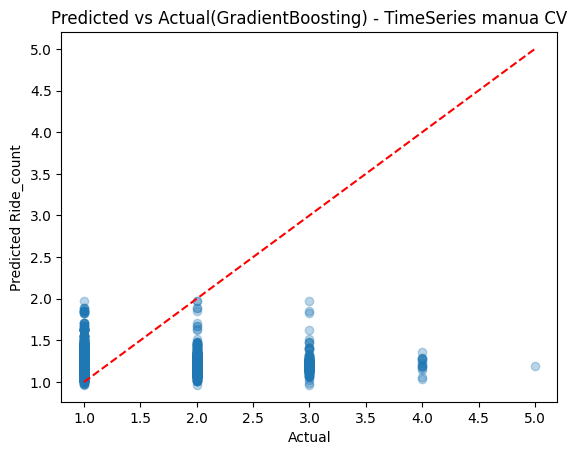

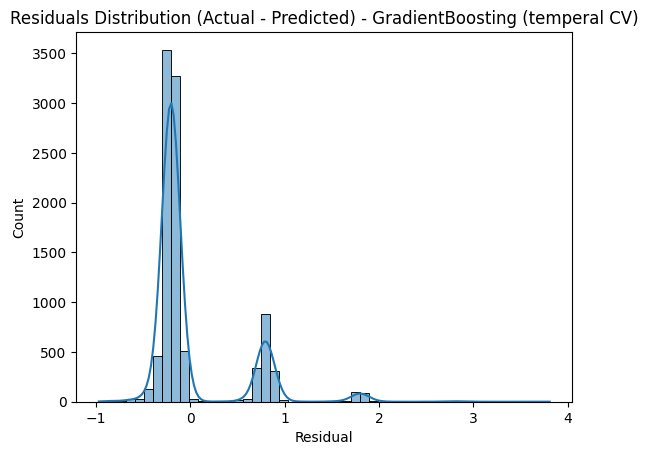

Feature importances:


,Feature,Importance
0,Hour,0.389840
1,Pickup_loc_code,0.375933
2,DayOfWeek,0.214998
3,IsWeekend,0.019229


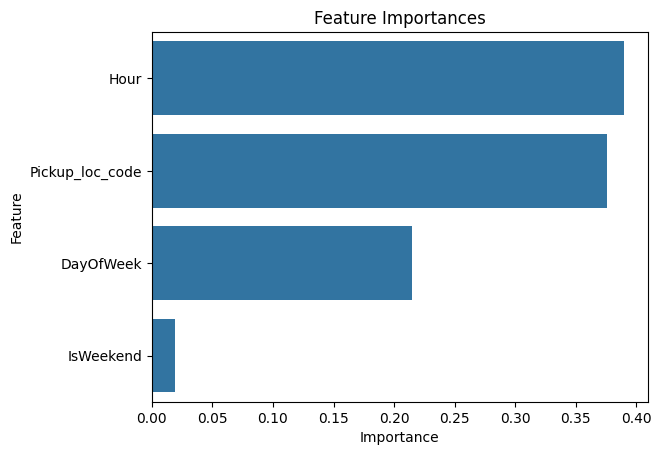

In [9]:
import seaborn as sns, matplotlib.pyplot as plt

valid = ~np.isnan(y_pred)
mae = mean_absolute_error(y_ts[valid], y_pred[valid])
rmse = np.sqrt(mean_squared_error(y_ts[valid], y_pred[valid]))
r2 = r2_score(y_ts[valid], y_pred[valid])
print(f"Final Metrics | MAE {mae:.3f} | RMSE {rmse:.3f} | R2 {r2:.3f}")

# Pred vs Actual
plt.scatter(y_ts[valid], y_pred[valid], alpha=0.3)
plt.plot([y_ts.min(), y_ts.max()],[y_ts.min(), y_ts.max()],'r--')
plt.xlabel("Actual"); plt.ylabel("Predicted Ride_count"); plt.title("Predicted vs Actual(GradientBoosting) - TimeSeries manua CV")
plt.show()

# Residuals
residuals = y_ts[valid] - y_pred[valid]
sns.histplot(residuals, bins=50, kde=True)
plt.xlabel("Residual")
plt.title("Residuals Distribution (Actual - Predicted) - GradientBoosting (temperal CV)")
plt.show()

# Feature Importances (if ensemble)
if best_model in ["RandomForest","GradientBoosting","XGBoost","LightGBM"]:
    base_model.fit(X_ts, y_ts)
    fi = pd.DataFrame({'Feature':FEATURES, 'Importance':base_model.feature_importances_}).sort_values('Importance', ascending=False)
    print("Feature importances:"); display(fi)
    sns.barplot(data=fi, x='Importance', y='Feature')
    plt.title("Feature Importances")
    plt.show()


***9. Visualize Model Comparison Results***

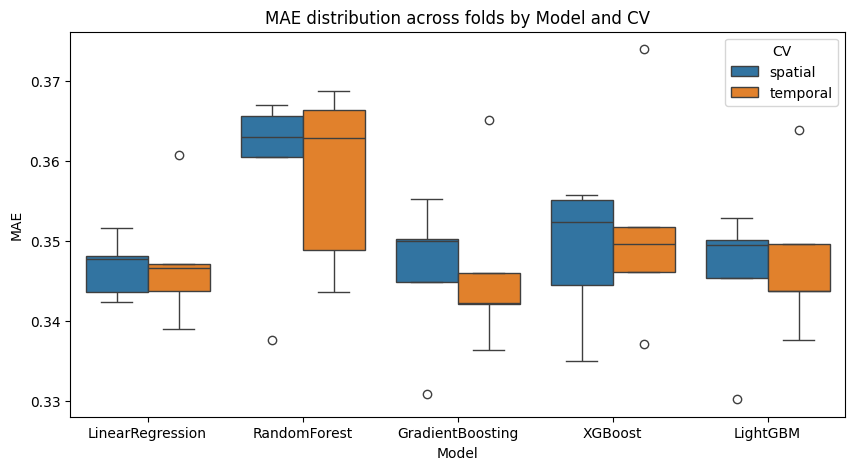

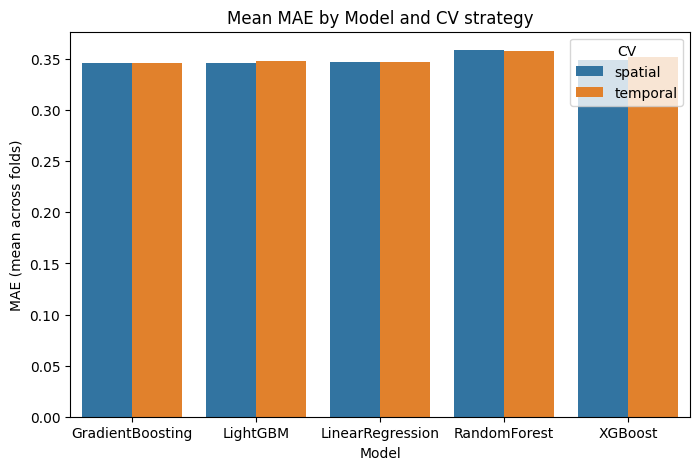

In [10]:
# Convert results dict into DataFrame
rows = []
for cv_type in ['spatial','temporal']:
    for model_name, metrics in results[cv_type].items():
        for fold_idx, val in enumerate(metrics['MAE']):
            rows.append({'CV':cv_type,'Model':model_name,'Fold':fold_idx,'MAE':val})
mae_df = pd.DataFrame(rows)

# Boxplot of MAE across folds
plt.figure(figsize=(10,5))
sns.boxplot(data=mae_df, x='Model', y='MAE', hue='CV')
plt.title("MAE distribution across folds by Model and CV")
plt.show()

# Barplot of mean MAE
mean_df = mae_df.groupby(['CV','Model'])['MAE'].mean().reset_index()
plt.figure(figsize=(8,5))
sns.barplot(data=mean_df, x='Model', y='MAE', hue='CV')
plt.title("Mean MAE by Model and CV strategy")
plt.ylabel("MAE (mean across folds)")
plt.show()